# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [4]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

L_train = []
L_test = []

for i in range(len(y_train)):
    L_train.append(y_train[i][0])

for j in range(len(y_test)):
    L_test.append(y_test[j][0])

import numpy as np
test=np.array(L_train, dtype=np.uint8)
Y_train=np.array(L_train)
Y_test=np.array(L_test)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [6]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(Y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 50000
Number of testing examples = 10000
Image data shape = (32, 32, 3)
Number of classes = 10


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Sample Images


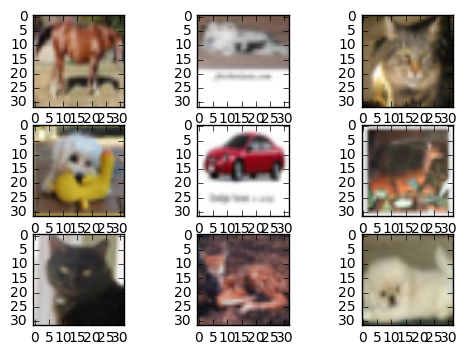

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
print('Sample Images')

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[random.randint(0, len(X_train))])
    

[]

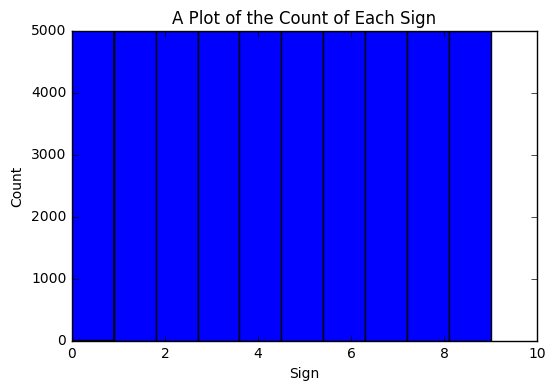

In [9]:
plt.hist(Y_train, bins=n_classes)
plt.title('A Plot of the Count of Each Sign')
plt.xlabel('Sign')
plt.ylabel('Count')
plt.plot()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Image:  6


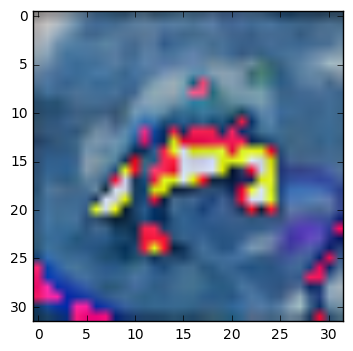

In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2
import numpy as np
import random as rnd

def plot_images(index):
    plt.imshow(X_train[index])
    print("Image: ", Y_train[index])
    
# zero center
X_train = (X_train - X_train.mean()) #/ (np.max(X_train) - np.min(X_train))
X_test = (X_test - X_test.mean())

plot_images(0)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I chose to only use **Mean Subtraction:** on the input. As explained under http://cs231n.github.io/neural-networks-2/#reg, this corresponds to center the cloud of data around the origin (geometric interpretation).
In order to preserve information, no grayscale imaging is carried out.

To confirm this approach I tested alternative/additional approaches like  **Normalization**, what proved to yield no improvement, as anticipated in above mentioned article

In [11]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

X_train_appended=[]
Y_train_appended=[]

# find the largest number of occurrences of any single traffic sign
def determine_largest_count():
    num_occurrences=[]
    for i in range(len(set(Y_train))):
        num_occurrences.append(list(Y_train).count(i))
    return np.amax(num_occurrences)

def add_images(count):
    # rotate images slightly and increase number of training samples
    # rows and cols for matrix operation
    rows,cols,depth = X_train[0].shape
            
    for i in range(len(X_train)):
        # Add rotated images, enlarge test set
        img=X_train[i]
        X_train_appended.append(img)
        Y_train_appended.append(Y_train[i])
        for j in range(count):
            X_train_appended.append(cv2.warpAffine(img,cv2.getRotationMatrix2D((cols/2,rows/2), random.randint(0,29)-15 ,1),(cols,rows)))
            Y_train_appended.append(Y_train[i])

inflation_factor=2
#add_images(inflation_factor)
assert len(X_train_appended)==len(Y_train_appended)

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

if (len(X_train_appended) > 0):
    X_train=X_train_appended
    Y_train=Y_train_appended

print("New training image set size: ", len(X_train))


New training image set size:  50000


In [12]:
# split new training set
X_train, Y_train = shuffle(X_train, Y_train)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
    *  Data sets are already provided split up into training set and test set; the training set has been shuffled in an attempt to support the training process by presenting data randomly rather than in consecutive ofder
    * Training data was separated from validation data 9:1
    * Optional: Additional data has been added, what proved very valuable  during testing. I used an approach reading each image, rotating it within a small range of randomly chosen angles and adding this slightly modified image to the training set. This way, the number of available training data was inflated significantly, what should help in overfitting avoidance. During testing, an increase by a factor of 8 yielded  best results


In [15]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.001
    Padding='VALID'
    W_lambda = 3.0
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x40.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 40), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(40))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding=Padding) + conv1_b
    
    # L2 Regularization
    #conv1_W = -W_lambda*conv1_W
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x40. Output = 14x14x40.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=Padding)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 40, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding=Padding) + conv2_b
    
    # L2 regularization
    #conv2 = -W_lambda*conv2
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=Padding)
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1024(1024 for SAME vs 400 for VALID padding). Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits
    

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My model is a slightly modified LeNet-5 CNN with added L2 regularization, an approach that should help in overfitting avoidance:
    Layer 1: 
        * Convolution
        * L2 Regularization
        * Activation  (ReLU)
        * Pooling
    Layer 2: 
        * Convolution
        * L2 Regularization
        * Activation  (ReLU)
        * Pooling
        * Flatten
    Layer 3:
        * Fully Connected
        * Activation (ReLU)
    Layer 4:
        * Fully Connected
        * Activiation (ReLU)
    Layer 5:
        * Fully connected
        
As mentioned above, the network uses preprocessed data (Mean Subtraction) and 3 color channels

In [18]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

rate = 0.0001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()   

EPOCHS = 30
BATCH_SIZE = 50

def evaluate(X_data, Y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], Y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    avg_accuracy=[]
    for i in range(EPOCHS):
        X_train, Y_train = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_val, Y_val)
        print("EPOCH {} ...".format(i+1), "Accuracy = {:.6f}".format(validation_accuracy))
        if i > EPOCHS*2/3:
            rate = 0.00001
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ... Accuracy = 0.259400
EPOCH 2 ... Accuracy = 0.322800
EPOCH 3 ... Accuracy = 0.354400
EPOCH 4 ... Accuracy = 0.394600
EPOCH 5 ... Accuracy = 0.426200
EPOCH 6 ... Accuracy = 0.456000
EPOCH 7 ... Accuracy = 0.483400
EPOCH 8 ... Accuracy = 0.522000
EPOCH 9 ... Accuracy = 0.538600
EPOCH 10 ... Accuracy = 0.564600
EPOCH 11 ... Accuracy = 0.574000
EPOCH 12 ... Accuracy = 0.595400
EPOCH 13 ... Accuracy = 0.602200
EPOCH 14 ... Accuracy = 0.621000
EPOCH 15 ... Accuracy = 0.629200
EPOCH 16 ... Accuracy = 0.641200
EPOCH 17 ... Accuracy = 0.643000
EPOCH 18 ... Accuracy = 0.652800
EPOCH 19 ... Accuracy = 0.651000
EPOCH 20 ... Accuracy = 0.670000
EPOCH 21 ... Accuracy = 0.671000
EPOCH 22 ... Accuracy = 0.676600
EPOCH 23 ... Accuracy = 0.678200
EPOCH 24 ... Accuracy = 0.688000
EPOCH 25 ... Accuracy = 0.694400
EPOCH 26 ... Accuracy = 0.695600
EPOCH 27 ... Accuracy = 0.695400
EPOCH 28 ... Accuracy = 0.691600
EPOCH 29 ... Accuracy = 0.703000
EPOCH 30 ... Accuracy = 0.708400
Model 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

        Optimizer: Adam
        Batch Size: I used various batch sizes; batch sizes from 50 to 80 yielded best results
        Training  Epochs: 200
        Learning rate: starting 0.001, after 2/3 of epochs reducing to 0.0001
        Padding: VALID
        mu: 0
        sigma: 0.001
        lambda (L2): 3.0

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

**Step 1**

Adopting the LeNet approach as taught in the Course, I first tried to implement a first working version of a CNN. Once this was accomplished, I continued answering the remaining questions, what helped in understanding the overall CNN/LeNet approach and additionally helped in getting used to tensorflow.

Once this was completed, I went ahead to inquire which parameters yields what changes to the overall results.
In particular, I tinkered with various approaches to adding more training samples, normalization  (what proved surprisingly difficult to get right), number of epochs, learning rate, parameter values (like mu, sigma, et).

I came up, finally, with interesting results:

    With an accuracy of 999,8** on the validation set, I obtained 0.939 on the test set

Now, while this result seems not that bad, there is certainly left room for further improvement. With an almost 100% rate on the validation set, yet a 6%-points lower score on the test set, I assumed an overfitting issue might be present.

Now, is a number of mitigation strategies, most notably L2 regularization; which I therefore implemented in addition.

**Testing Approach**

The overall approach to testing was the following:

Once a sufficiently satisfactory result was obtained, I used this result as a benchmark for subsequent paramter changes. The effects of the changes then have been tested using reduced numbers of epochs and addedd images, respectively. This approach helped in significantly reducing time required for testing. Typical values were not to add additional images and number of epochs ranging from 30 to 50.
Again, once a score deemed a sufficient improvement, I increased the number of epochs/added images again to confirm the conjectured improvement indeed persists over longer trainig runs.

**Test Set Evaluation**

In [19]:
#evaluate test set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    #check test set
    test_accuracy = evaluate(X_test, Y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))  

Test Accuracy = 0.690


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob, os
import matplotlib.image as mpimg

# read test images int
indir=os.listdir('test_images/')
indir.sort()
test_images=[]

# read custom images and scale to 32 32 3
for image_path in indir:
    image_path='test_images/'+image_path
    image =mpimg.imread(image_path)
    # resize to match image set
    image=cv2.resize(image, (32, 32), interpolation=cv2.INTER_NEAREST)
    test_images.append(image)

# display two in a row
num_images=len(test_images)
half_images=int(num_images/2+5)

# preserver original images
original_images=list(test_images)

for i in range(num_images):
    plt.subplot(half_images,2,i+1)
    plt.imshow(test_images[i])
    

In [ ]:
# helper functions
sign_names={1: "Speed Limit (30 km/h)",
            8: "Speed Limit 1(120 km/h)",
            6: "End of Speed Limit", 
            8: "Speed Limit 120 km/h", 
            11: "Right of Way at Next Intersection", 
            16: "Vehicles over 3.5 Metric Tons Prohibited", 
            17: "No Entry",
            25: "Road Work",
            33: "Turn Right Ahead",
            38: "Keep Right",
            40: "Roundabout Mandatory"}

# predict image classification
def predict_signs():
    num_examples = len(test_images)
    total_accuracy = 0
    sess = tf.get_default_session()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = test_images[offset:offset+BATCH_SIZE], Y_test_images[offset:offset+BATCH_SIZE]        
            prediction=tf.argmax(logits, 1)
            retval = sess.run([prediction],feed_dict={x: batch_x, y: batch_y})
    return retval

# compare if prediction correct
def determine_correct():
    num_examples = len(test_images)
    total_accuracy = 0
    sess = tf.get_default_session()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = test_images[offset:offset+BATCH_SIZE], Y_test_images[offset:offset+BATCH_SIZE]
            prediction=tf.argmax(logits, 1)
            retval = sess.run([correct_prediction],feed_dict={x: batch_x, y: batch_y})
    return retval

def predict():
    num_examples = len(test_images)
    total_accuracy = 0
    sess = tf.get_default_session()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = test_images[offset:offset+BATCH_SIZE], Y_test_images[offset:offset+BATCH_SIZE]        
            prediction=tf.argmax(logits, 1)
            probability=tf.nn.softmax(logits)
            retval = sess.run([probability],feed_dict={x: batch_x, y: batch_y})
    return retval
        
def visualize_prediction(index):
    sess = tf.get_default_session()
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        probabilities = predict()
        print("Probabilities for image no: ", index, "\n")
        print(probabilities[0][index], "\n")
    
        print("TopKV2: ")
        print(sess.run(tf.nn.top_k(tf.constant(probabilities[0][index]), k=3)), "\n")
        plt.imshow(test_images[index])
        
def print_prediction_for_image_no(index):
    print("Prediction: ", p[0][index], ", ", sign_names[p[0][index]], " correct? ", b[0][index], "")
    plt.imshow(original_images[index])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Living in Nuremberg, Germany I photographed  a number of photos I used for classification. One photo in particular appears rather distorted since taken from aside.I found it intersting to see if the image will be classified correctly

In [ ]:
plt.imshow(original_images[0])

Also, since taken at night, it appears blurry and overall image quality is poor.


The "No Entry" sign below is partly occluded with stickers, what may also get in the way of the classifier

In [ ]:
plt.imshow(original_images[5])

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

#read Y_test_images:
#read test_image labels
fname='Y_test_images.txt'
with open(fname) as f:    
    content = f.readlines()
    content = [x.strip() for x in content] 
    
# create 2D array and assign labels
Y_test_images=np.empty((num_images, ), dtype=np.uint8)
for i in range(num_images):
    Y_test_images[i,]=content[i]
    
#check the number of test images matches the respective labels
assert len(Y_test_images)==num_images

#zero center test images
test_images = (test_images - np.mean(test_images))

p = predict_signs()
b = determine_correct()
assert len(p)==len(b)

In [ ]:
print_prediction_for_image_no(0)

In [ ]:
print_prediction_for_image_no(1)

In [ ]:
print_prediction_for_image_no(2)

In [ ]:
print_prediction_for_image_no(3)

In [ ]:
print_prediction_for_image_no(4)

In [ ]:
print_prediction_for_image_no(5)

In [ ]:
print_prediction_for_image_no(6)

In [ ]:
print_prediction_for_image_no(7)

In [ ]:
print_prediction_for_image_no(8)

In [ ]:
print_prediction_for_image_no(9)

Even though prediction is wrong, the algorithm seems to have correctly identified the **arrow to the right**. 
Very interesting

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The algorithm seems to do well. That said, the overall classification rate seems to be slightly below the scores obtained using the test dataset. (0.959 vs 0.9*).

To find out more, a much larger dataset should be used to confirm the results using custom photos - after all, the custom test uses just 10 images.

In [ ]:
#evaluate test set
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    #check custom test set
    test_accuracy = evaluate(test_images, Y_test_images)
    print("Custom Signs Accuracy = {:.3f}".format(test_accuracy))

print("")   
print("Predictions vs Labels") 
print("")
print (Y_test_images)
print(predict_signs()[0])

As the values above indicate, only one out of 10 images has been classified wrongly.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
    
See discussions of images below.

**Image 0: Index no 1 is close to one, so the model seems pretty sure in this case**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

image_number=0
probabilities = visualize_prediction(image_number)

**Image 1: Again, the modes is very certain about its choice**

In [ ]:
image_number=1
probabilities = visualize_prediction(image_number)==len(b)    

**Image 2: Again, the model is 100% certain (which should be suspicious)**

In [ ]:
image_number=2
probabilities = visualize_prediction(image_number)==len(b)

**Image 4: Once again, the modes is very certain about its choice. **

Apparently, the stickers did not influence the model in a negative way

In [ ]:
image_number=4
probabilities = visualize_prediction(image_number)==len(b)

**Image 5: Once again, the mode is rather certain about its choice**:

In [ ]:
image_number=5
probabilities = visualize_prediction(image_number)==len(b)

(...)

The picture is similar for the remainder of the captured images.

Except for one:

**Image 4: The classifier is very certain about its choice. However, it is wrong**

The correct answer, however, is listed as second most likely choice identified, albeit there is a huge margin in probability.

In [ ]:
image_number=3
probabilities = visualize_prediction(image_number)==len(b)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.